In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, classification_report

### Load the Dataset

In [37]:
# Load the dataset
df = pd.read_excel("TrainDataset2024.xls")
df=df.drop('ID',axis=1)

### Data preprocessing

In [38]:
#replacing the 999 value to nan for easy removal

df.replace(999, np.nan, inplace= True)
df.dropna(inplace =True)
df.shape

(308, 120)

In [39]:
df = df.rename(columns={"pCR (outcome)": "PCR"})

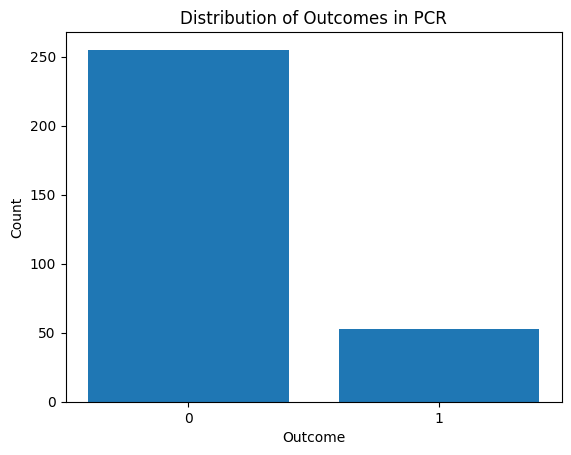

In [40]:
# plotting for zero and one value count in PCR column
outcomes = df['PCR'].value_counts()
outcome_labels =['0','1']
outcome_values = outcomes.values
plt.bar(outcome_labels, outcome_values)
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Distribution of Outcomes in PCR')
plt.show()

In [41]:
# Calculate Z-scores for the entire dataset
z_scores = np.abs((df - df.mean()) / df.std())

# Identify rows that have z-scores above the threshold (3 in this case)
outliers = (z_scores > 3).any(axis=1)

# Print the number of outliers
print(f"Number of outliers: {outliers.sum()}")


Number of outliers: 62


In [42]:
# Remove outliers from the dataset
df_no_outliers = df[~outliers]

In [43]:
df1 = df.copy()
# checking for correlated features of dataset
def correlation(data, threshold):
    col_corr = {}  # Dictionary to store correlated features
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # We are interested in absolute coefficient value
                colname = corr_matrix.columns[i]
                if colname not in col_corr:
                    col_corr[colname] = set()
                col_corr[colname].add(corr_matrix.columns[j])

    return col_corr

corr_features = correlation(df1, 0.8)
print('correlated features: ', len(corr_features))

correlated features:  82


In [44]:
# removing the correlated features
df_corr= df1.drop(labels=corr_features, axis=1)
df_corr.shape

(308, 38)

In [45]:
# dataset using correlated feature selection
X_corr = df_corr.drop(["PCR","RelapseFreeSurvival (outcome)"],axis=1)
y_corr = df_corr["PCR"]

In [46]:
X_corr.head()

Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  HistologyType  LNStatus  \
0  41.0   0  0.0   0.0              1.0         3.0            1.0       1.0   
1  39.0   1  1.0   0.0              0.0         3.0            1.0       1.0   
2  31.0   0  0.0   0.0              1.0         2.0            1.0       0.0   
3  35.0   0  0.0   0.0              1.0         3.0            1.0       1.0   
4  61.0   1  0.0   0.0              0.0         2.0            1.0       0.0   

   TumourStage  Gene  ...  original_gldm_DependenceEntropy  \
0            2   1.0  ...                         4.529461   
1            2   0.0  ...                         2.799725   
2            2   1.0  ...                         2.863091   
3            3   1.0  ...                         2.756432   
4            2   1.0  ...                         2.676170   

   original_gldm_SmallDependenceEmphasis  \
0                               0.005563   
1                               0.006518   
2                               0.007181   
3                               0.004902   
4                               0.007222   

   original_glrlm_LongRunLowGrayLevelEmphasis  \
0                                   10.779989   
1                                   27.650685   
2                                   25.338218   
3                                   31.461354   
4                                   27.916261   

   original_glrlm_ShortRunHighGrayLevelEmphasis  \
0                                      0.789987   
1                                      0.442279   
2                                      0.503046   
3                                      0.399896   
4                                      0.473278   

   original_glszm_GrayLevelNonUniformity  \
0                              27.545455   
1                              78.025000   
2                              72.027027   
3                              99.019802   
4                              56.034483   

   original_glszm_GrayLevelNonUniformityNormalized  \
0                                         0.834711   
1                                         0.975313   
2                                         0.973338   
3                                         0.980394   
4                                         0.966112   

   original_glszm_SizeZoneNonUniformityNormalized  \
0                                        0.180900   
1                                        0.198125   
2                                        0.275749   
3                                        0.253014   
4                                        0.216409   

   original_glszm_SmallAreaEmphasis  original_ngtdm_Busyness  \
0                          0.403535               473.464852   
1                          0.444391                59.459710   
2                          0.534549                33.935384   
3                          0.506185                46.859265   
4                          0.462282                39.621023   

   original_ngtdm_Strength  
0                 0.000758  
1                 0.003685  
2                 0.006447  
3                 0.004543  
4                 0.005626  

[5 rows x 36 columns]

In [47]:
# saving the feature in text file for future use in model training and prediction
with open('30cor.txt', 'w') as f:
    for feature in X_corr.columns:
        f.write(feature + '\n')


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Split the correlated feature into training and testing sets ( correlated features)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_corr, y_corr, test_size=0.2,shuffle=True,random_state=42)
# Standardize the features
scaler = StandardScaler()
X_train_sc1 = scaler.fit_transform(X_train1)
X_test_sc1 = scaler.fit_transform(X_test1)

In [49]:
X_train1.shape, 

((246, 36),)

In [50]:
# dataset using correlated feature selection for forward feature selection
X_for = df_corr.drop(["PCR","RelapseFreeSurvival (outcome)"],axis=1)
y_for = df_corr["PCR"]

### Random forest Final Model

In [51]:
import joblib
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score

In [52]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_corr, y_corr, test_size=0.3, shuffle=True, random_state=64)

# Standardizing the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Initial training of Random Forest model (without SMOTE)
rf_classifier = RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=15, n_estimators=25, random_state=42)
rf_classifier.fit(X_train_norm, y_train)

# Predicting class labels for testing data (initial prediction)
y_pred = rf_classifier.predict(X_test_norm)

# Calculating classification report and balanced accuracy score (initial performance)
report = classification_report(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print('Initial Classification Report:')
print(report)

print('\nInitial Balanced Accuracy Score:')
print(balanced_accuracy)

Initial Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        74
         1.0       0.00      0.00      0.00        19

    accuracy                           0.80        93
   macro avg       0.40      0.50      0.44        93
weighted avg       0.63      0.80      0.71        93


Initial Balanced Accuracy Score:
0.5


C:\Users\LLR User\miniconda3\envs\MLE\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LLR User\miniconda3\envs\MLE\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LLR User\miniconda3\envs\MLE\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Now applying SMOTE for oversampling the minority class in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_norm, y_train)

# Retraining the Random Forest model on the SMOTE-resampled data
rf_classifier_smote = RandomForestClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=15, n_estimators=25, random_state=42)
rf_classifier_smote.fit(X_train_smote, y_train_smote)

# Predicting class labels for testing data (after SMOTE resampling)
y_pred_smote = rf_classifier_smote.predict(X_test_norm)

# Calculating classification report and balanced accuracy score (after SMOTE)
report_smote = classification_report(y_test, y_pred_smote)
balanced_accuracy_smote = balanced_accuracy_score(y_test, y_pred_smote)

print('\nClassification Report After SMOTE:')
print(report_smote)

print('\nBalanced Accuracy Score After SMOTE:')
print(balanced_accuracy_smote)


Classification Report After SMOTE:
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87        74
         1.0       0.50      0.47      0.49        19

    accuracy                           0.80        93
   macro avg       0.68      0.68      0.68        93
weighted avg       0.79      0.80      0.79        93


Balanced Accuracy Score After SMOTE:
0.6760312944523471


In [54]:
# Ensure that you are using X_train and y_train for cross-validation, not X_train and y_corr
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_corr, y_corr, test_size=0.2, shuffle=True, random_state=60)

# Initialize the model
rf_classifier = RandomForestClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=15, n_estimators=1000, random_state=42)

# Perform 10-fold cross-validation on the dataset using RandomForest
k = KFold(n_splits=10)
scores = cross_val_score(rf_classifier, X_train, y_train, cv=k)

# Printing the accuracy of each fold
print("Accuracy for each fold:")
for i in range(len(scores)):
    print(f"Fold {i}: {scores[i]:.4f}")

# Printing the average accuracy
average_accuracy = np.mean(scores)
print(f"Average accuracy: {average_accuracy:.4f}")


Accuracy for each fold:
Fold 0: 0.8000
Fold 1: 0.8000
Fold 2: 0.8000
Fold 3: 0.9200
Fold 4: 0.8000
Fold 5: 0.8000
Fold 6: 0.8750
Fold 7: 0.7917
Fold 8: 0.8750
Fold 9: 0.8750
Average accuracy: 0.8337


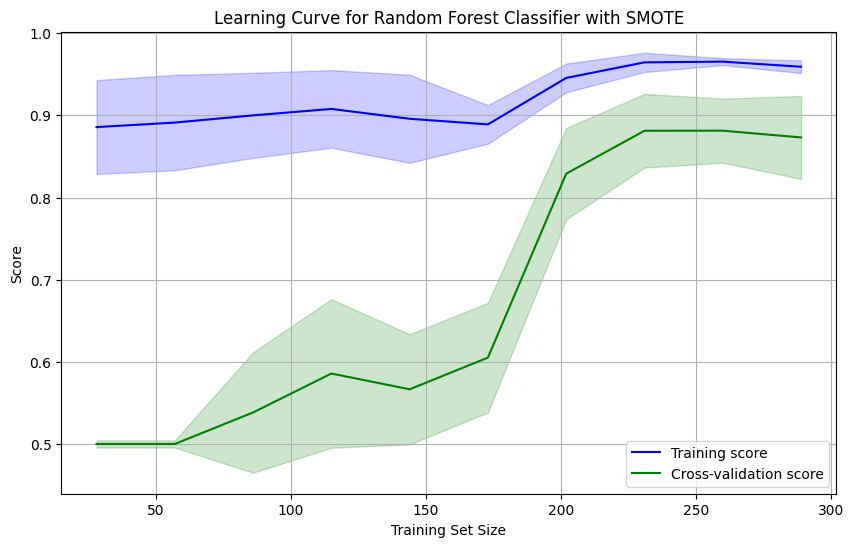

In [55]:
# Plotting Learning Curve for Random Forest model with SMOTE
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier_smote, X_train_smote, y_train_smote, cv=5, n_jobs=-1,
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
)

# Calculate mean and std for train and test scores
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green')

# Plotting the confidence intervals
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)

plt.title('Learning Curve for Random Forest Classifier with SMOTE')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
# Save the Random Forest model and scaler using joblib
joblib.dump(rf_classifier_smote, 'rf_classifier_smote.pkl')  # Save the trained model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for standardizing the data

['scaler.pkl']

In [57]:
# ---- Loading the model and scaler from the pickle file ----
# Load the trained model and scaler from the saved pickle files
loaded_rf_model = joblib.load('rf_classifier_smote.pkl')
loaded_scaler = joblib.load('scaler.pkl')

# Now, let's use the loaded model and scaler to make predictions on new data
# Assume df_test is your test data
df_test = pd.read_excel("FinalTestDataset2024.xls")

# Apply the same feature selection
with open('30cor.txt', 'r') as file:
    features = [line.strip() for line in file.readlines()]

df_test_selected = df_test[features]

# Transform the test data using the loaded scaler
X_test_sc = loaded_scaler.transform(df_test_selected)

# Make predictions using the loaded Random Forest model
y_pred_loaded = loaded_rf_model.predict(X_test_sc)

# Count occurrences of predicted classes
count_1 = np.sum(y_pred_loaded == 1)
count_0 = np.sum(y_pred_loaded == 0)

# Print predictions and counts
print("Predictions on Test Dataset:", y_pred_loaded)
print(f"Number of 1s in predictions: {count_1}")
print(f"Number of 0s in predictions: {count_0}")

Predictions on Test Dataset: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Number of 1s in predictions: 41
Number of 0s in predictions: 92


In [58]:
import pandas as pd
import numpy as np

# Ensure the 'ID' column exists
if 'ID' not in df_test.columns:
    raise ValueError("The input test dataset must contain an 'ID' column.")

# Create a DataFrame for predictions
output_df = pd.DataFrame({
    'ID': df_test['ID'],
    'Prediction': y_pred_loaded
})

# Save the predictions to an Excel file in 'xlsx' format
output_file_name = 'finalPCRoutput.xlsx'
output_df.to_excel(output_file_name, index=False)

print(f"Predictions have been saved to {output_file_name}")


Predictions have been saved to finalPCRoutput.xlsx
